## **Importing Libraries**

In [2]:
import numpy as np 
import pandas as pd
import os
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import time
import joblib

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone
import umap
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


2026-01-11 12:01:31.547480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768132891.719133      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768132891.771573      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768132892.164436      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768132892.164480      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768132892.164483      55 computation_placer.cc:177] computation placer alr

##  **Data Exploiration**

In [3]:
data = pd.read_csv('/kaggle/input/otto-group-product-classification-challenge/train.csv')
print(data.shape)
data.head()

(61878, 95)


,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


In [4]:
# Features in hand
X = data.drop(columns=["id", "target"])

In [5]:
# target y in hand
y = data['target']

In [6]:
n_classes = y.unique()

###  Missing values

In [54]:
print(data.isna().sum().sum())
(data.isna().mean() * 100).sort_values(ascending=False)

0


id         0.0
feat_1     0.0
feat_2     0.0
feat_3     0.0
feat_4     0.0
          ... 
feat_90    0.0
feat_91    0.0
feat_92    0.0
feat_93    0.0
target     0.0
Length: 95, dtype: float64

No missing value => Great

###  Data types:

In [25]:
data.dtypes.value_counts()

int64     94
object     1
Name: count, dtype: int64

All of them are of the right type => Great.

### Duplicates

In [26]:
data.duplicated().sum()

np.int64(0)

No duplicates => Great

### Outliers  

In [22]:
def iqr_outlier_stats(X):
    stats = []

    for col in X.columns:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        outliers = ((X[col] < lower) | (X[col] > upper)).sum()
        outlier_pct = outliers / len(X) * 100

        stats.append({
            "feature": col,
            "outliers_count": outliers,
            "outliers_pct": outlier_pct,
            "lower_bound": lower,
            "upper_bound": upper
        })

    return pd.DataFrame(stats).set_index("feature")

In [23]:
outlier_df = iqr_outlier_stats(X)
outlier_df.sort_values("outliers_pct", ascending=False).head(10)

,outliers_count,outliers_pct,lower_bound,upper_bound
feature,,,,
feat_60,15420,24.920004,0.0,0.0
feat_35,13828,22.347199,0.0,0.0
feat_89,13630,22.027215,0.0,0.0
feat_92,13592,21.965804,0.0,0.0
feat_4,13430,21.703998,0.0,0.0
feat_76,13391,21.640971,0.0,0.0
feat_80,13313,21.514916,0.0,0.0
feat_75,13310,21.510068,0.0,0.0
feat_85,12964,20.950903,0.0,0.0


In [24]:
(outlier_df["outliers_pct"] > 0).mean() * 100

np.float64(100.0)

Important: I guess it's because most of values are 0 so the IQR is also 0 (so all the values that are not 0 are outliers with this method ) BUT!! it does not mean they are outliers, it's an information..... 

### Ploting some features distribution

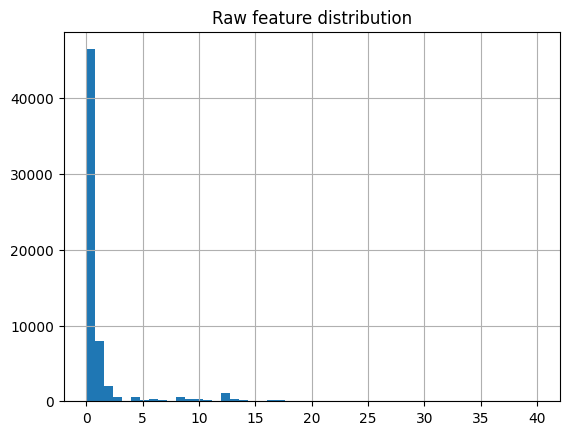

In [4]:
X["feat_60"].hist(bins=50)
plt.title("Raw feature distribution")
plt.show()

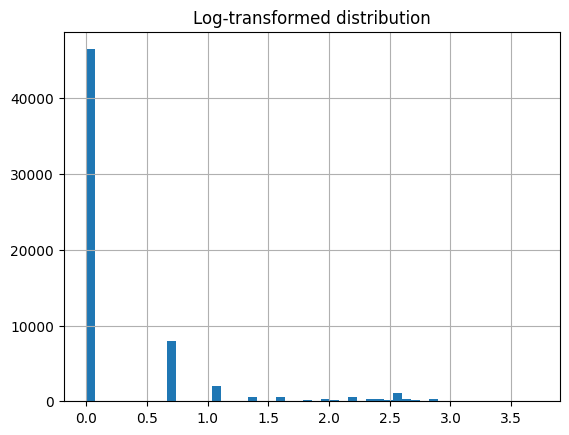

In [5]:
# transformed log1
np.log1p(X["feat_60"]).hist(bins=50)
plt.title("Log-transformed distribution")
plt.show()

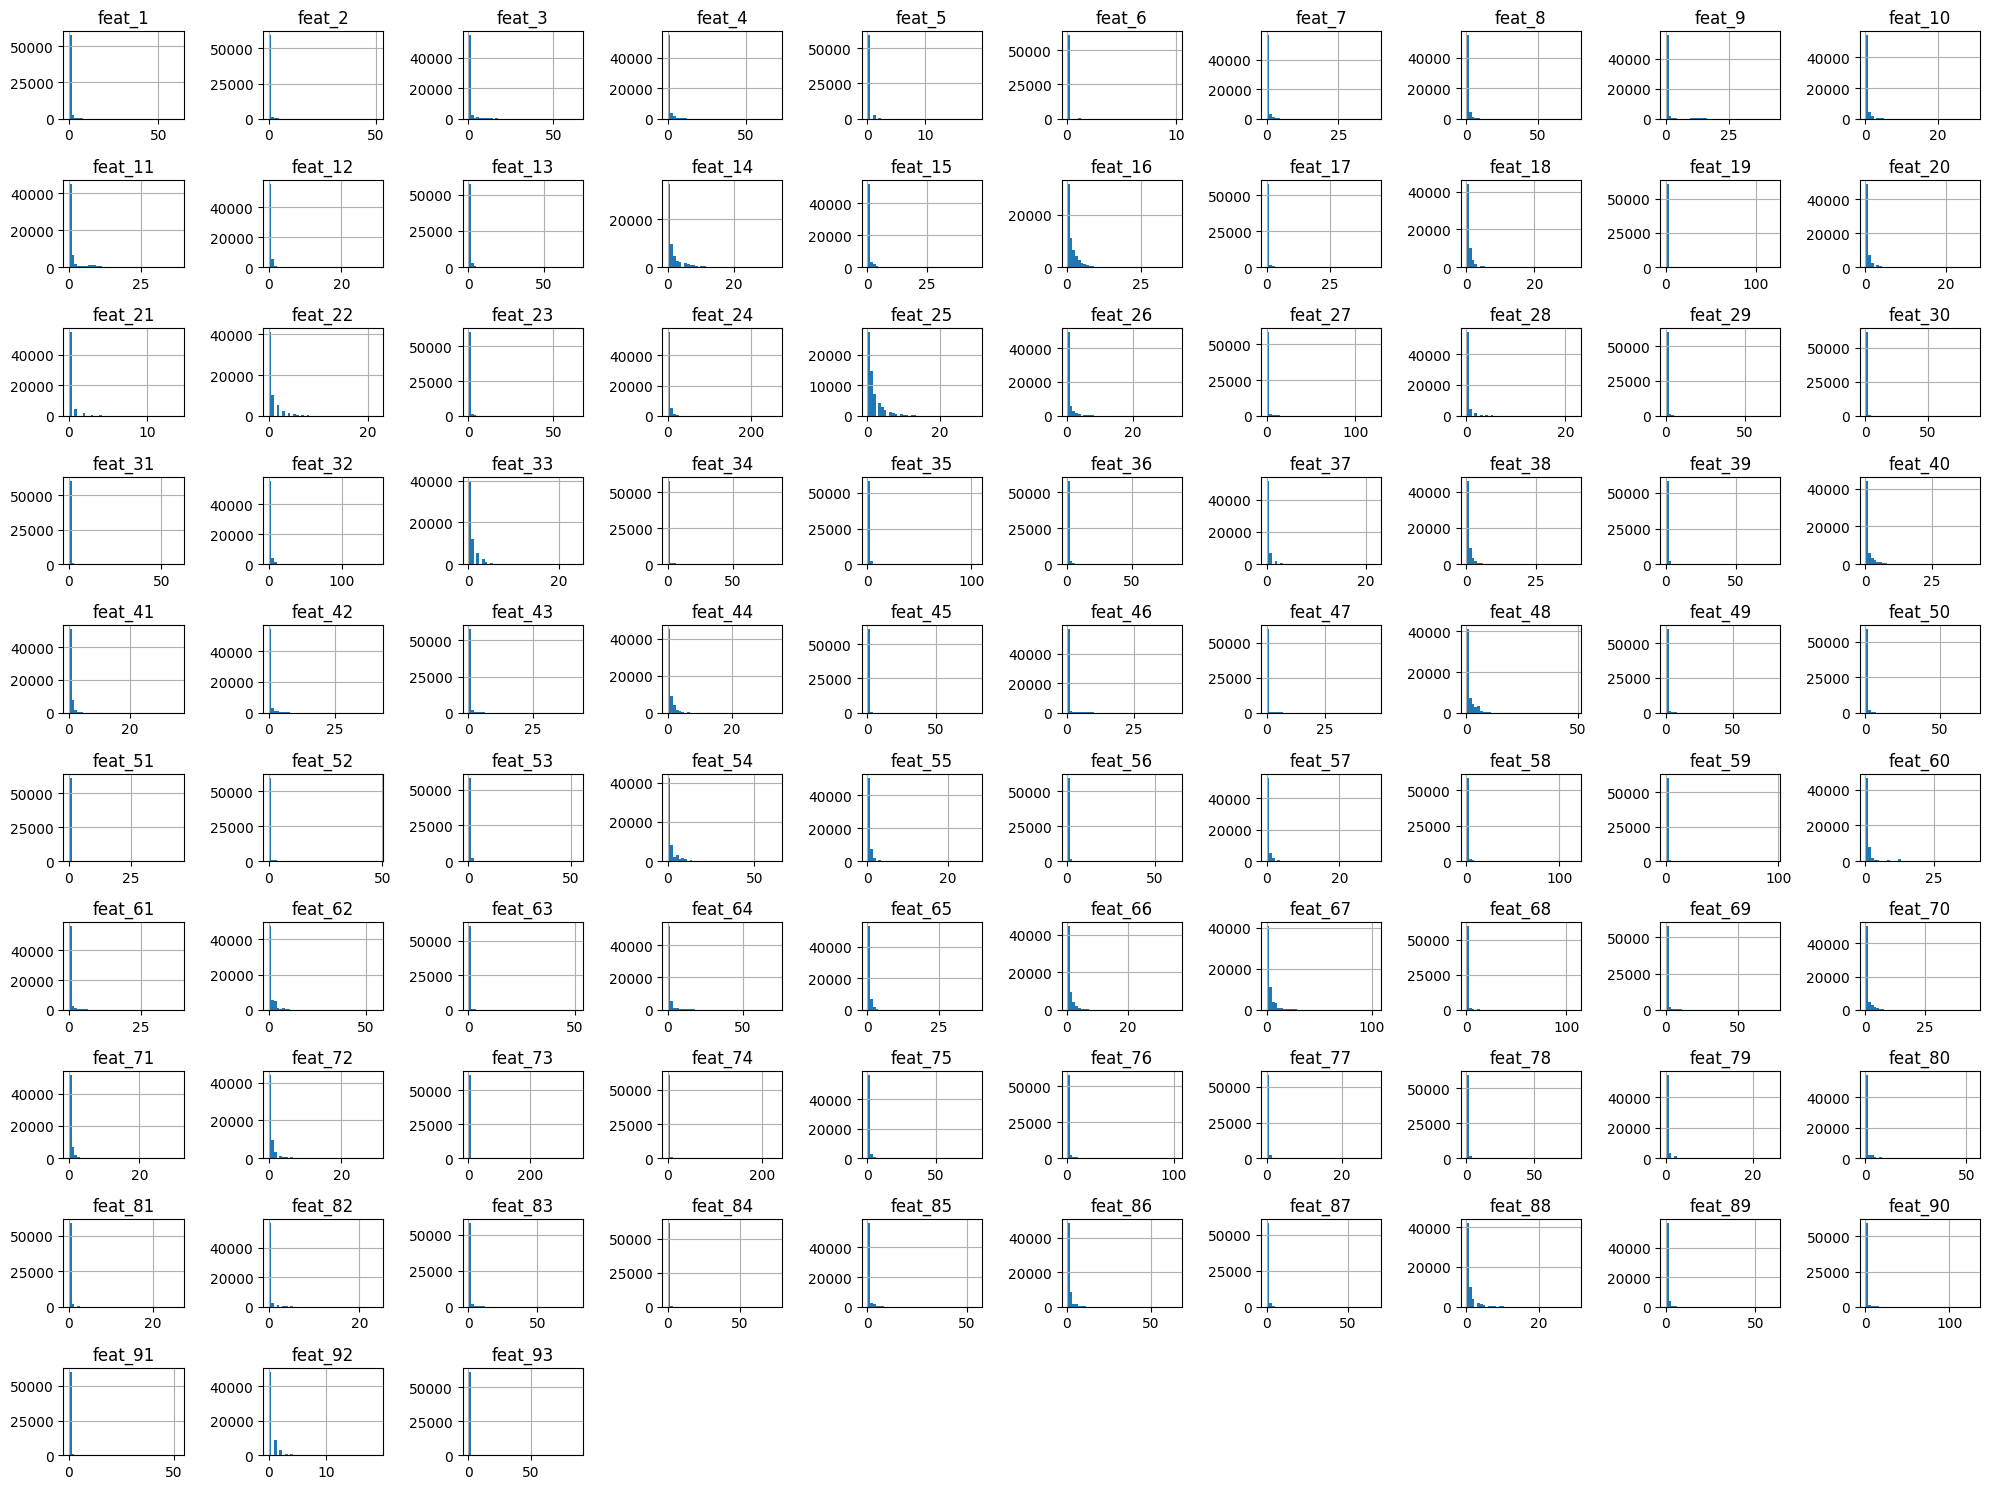

In [10]:
# ploting everything because why not 
X.hist(
    bins=40,
    figsize=(20, 15),
    layout=(10, 10)
)
plt.tight_layout()
plt.show()

In [8]:
# zeroes precentage
total_zeros = (X == 0).sum().sum()
total_zeros / X.size * 100

np.float64(79.34165981134575)

In [12]:
skewness = X.skew().sort_values(ascending=False)
skewness.head(10)

feat_30    36.519625
feat_73    33.987365
feat_93    33.766676
feat_84    32.459230
feat_51    31.154957
feat_74    23.787303
feat_23    21.330393
feat_29    20.466676
feat_63    20.009481
feat_45    19.189347
dtype: float64

I am noticing that most of the values are 0 and they are spread out (heavy skew + zeros) (positive integers) i suspect the features are countes of something like the number of a feature of a product => i am going to try standard transforms later:

* log

* sqrt

* scaling

###  Target Classes

In [10]:
# how many classes do we have 
y.unique()

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [51]:
# checking if there is class imbalance
# Percentage of each class
class_percent = y.value_counts(normalize=True) * 100
print(class_percent) 
good_percentage = 100 / len(y.unique())
print(f"Good percentage would be {good_percentage:.1f}%")

target
Class_2    26.054494
Class_6    22.843337
Class_8    13.678529
Class_3    12.935130
Class_9     8.007693
Class_7     4.588060
Class_5     4.426452
Class_4     4.348880
Class_1     3.117425
Name: proportion, dtype: float64
Good percentage would be 11.1%


===> Not good for some models 

## Exploring Features
To decide if i even need feature reduction: using rule of thumb samples ≥ 10 × features
144368 > 93 * 10 
=> so feature reduction is optionell  

### Features Variance

In [56]:
# features that barely change across the dataset: Features with almost the same value for every row carry little to no information.
vt = VarianceThreshold(threshold=0.1)
vt.fit(X)

VarianceThreshold(threshold=0.1)

In [57]:
variances = pd.Series(vt.variances_, index=X.columns)
to_remove = variances[variances <= 0.1]
to_keep = variances[variances > 0.1]

print("Total features:", X.shape[1])
print("Features to REMOVE:", len(to_remove))
print("Features to KEEP:", len(to_keep))


Total features: 93
Features to REMOVE: 1
Features to KEEP: 92


In [40]:
# lowest variance
to_remove.sort_values()

feat_6    0.046368
dtype: float64

In [41]:
variances.describe()

count    93.000000
mean      5.723460
std       6.202393
min       0.046368
25%       1.351252
50%       3.614860
75%       7.772844
max      33.445239
dtype: float64

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(variances, bins=50)
plt.axvline(0.01)
plt.xlabel("Feature Variance")
plt.ylabel("Count")
plt.title("Feature Variance Distribution")
plt.show()

###  Correlations & Mutual information

In [7]:
# Linear relationships (between features)
pearson_corr = X.corr()

# Monotonic / non-linear (between features)
spearman_corr = X.corr(method="spearman")

# General dependency with target
mi = mutual_info_classif(X, y)

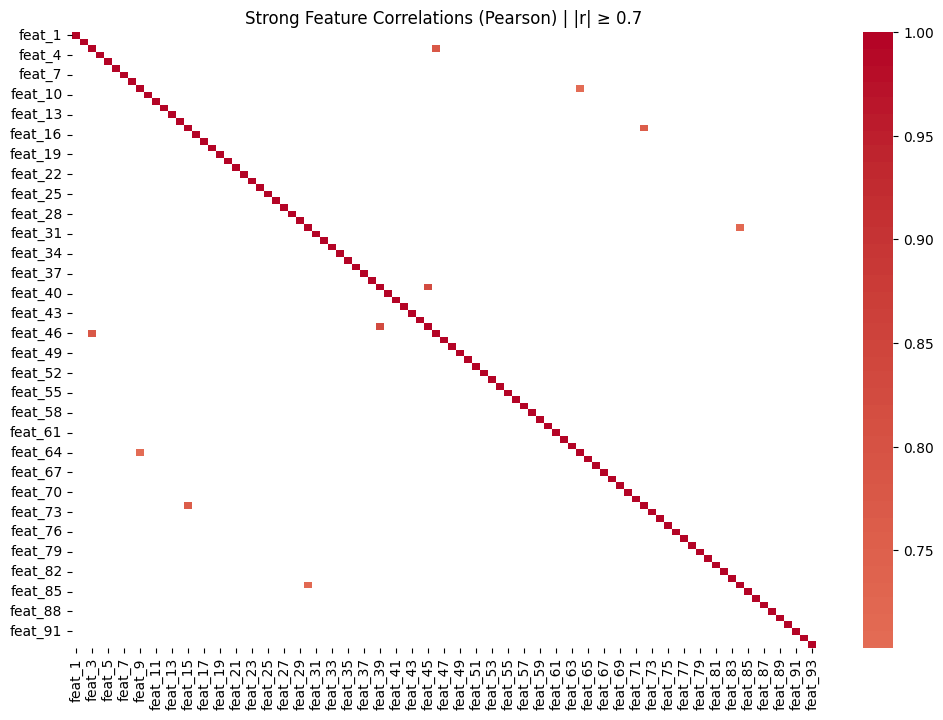

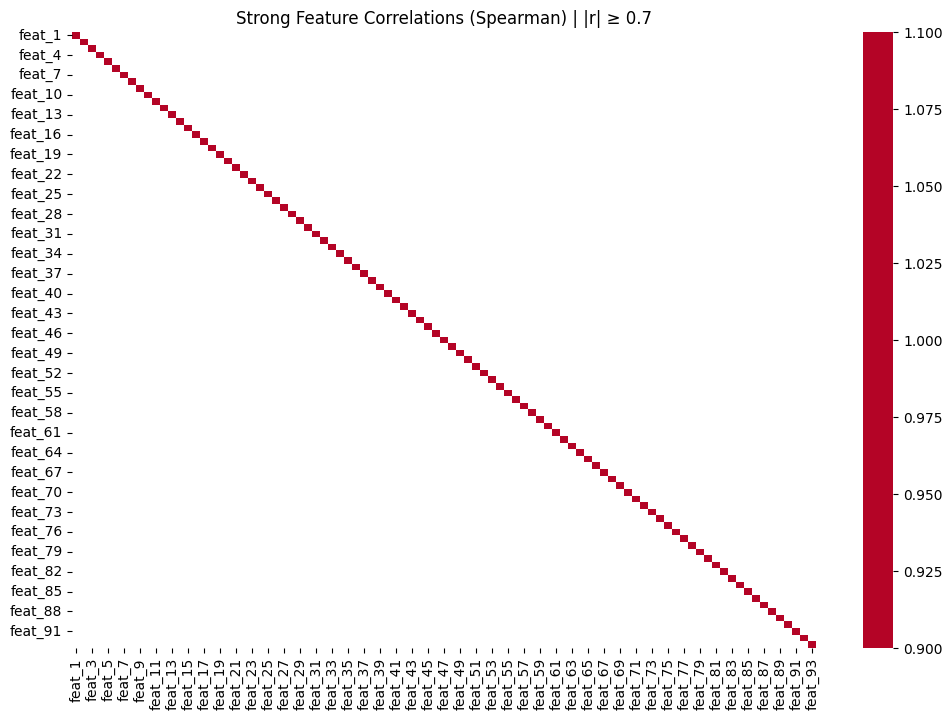

In [8]:
# plot only the heat map of corr > 0.7 between two features with the two corr methods 
corrs = {
    "Pearson": pearson_corr,
    "Spearman": spearman_corr
}

for name, corr in corrs.items():
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr,
        cmap="coolwarm",
        center=0,
        mask=abs(corr) < 0.7
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f"Strong Feature Correlations ({name}) | |r| ≥ 0.7")
    plt.show()

In [20]:
# summerizing the high correated features (to delete one later maybe)
threshold = 0.7
corr = pearson_corr.abs()  

upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(bool)
)

high_corr_pairs = (
    upper.stack()
    .reset_index()
)

high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]

high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"] > threshold]

high_corr_pairs.sort_values(by="Correlation", ascending=False)

,Feature_1,Feature_2,Correlation
2798,feat_39,feat_45,0.824146
225,feat_3,feat_46,0.777517
1253,feat_15,feat_72,0.764664
2315,feat_30,feat_84,0.716862
762,feat_9,feat_64,0.702951


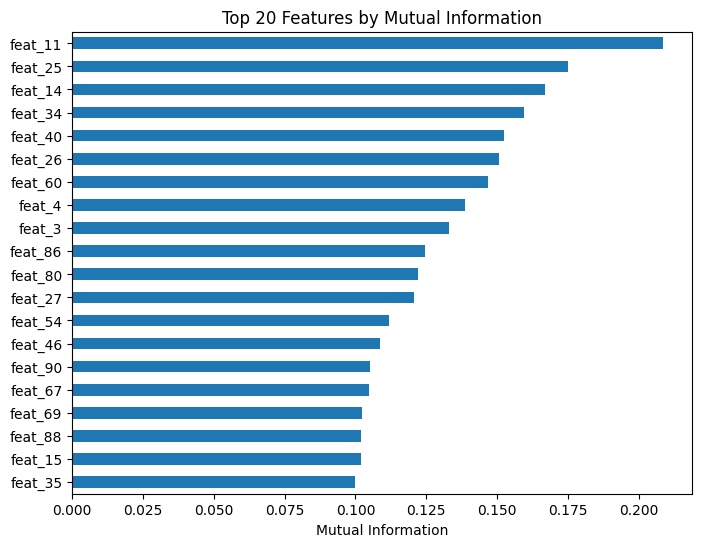

In [12]:
# ploting the top 20 mi features 
mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)
plt.figure(figsize=(8, 6))
mi_series.head(20).plot(kind="barh")
plt.xlabel("Mutual Information")
plt.title("Top 20 Features by Mutual Information")
plt.gca().invert_yaxis()
plt.show()

In [13]:
# taking a closer look into mi
mi_series = pd.Series(mi, index=X.columns)

In [15]:
# the features with the lowest mi 
bottom_mi_features = mi_series.sort_values().head(10)
bottom_mi_features

feat_12    0.001351
feat_6     0.001478
feat_65    0.009480
feat_5     0.010437
feat_63    0.013284
feat_93    0.015027
feat_51    0.016617
feat_84    0.017661
feat_77    0.019079
feat_10    0.021366
dtype: float64

In [16]:
mi_series.describe() # just to see if the lowest ones are that bad

count    93.000000
mean      0.067135
std       0.042422
min       0.001351
25%       0.038979
50%       0.053772
75%       0.090867
max       0.206888
dtype: float64

Not That Bad....

In [ ]:
# Brain storming and thoughts

# To Try:
# cross-validation
# maybe reursive feature elemination
# Number of non-zeros elements in each row as a new feature
# Ranking-based features (The heighest value features ) which features are the biggest for this row ? 

# Models to try:
# Xgboost 
# random forest
# logistic regression
# neural networks 
# naive bayes
# model stacking (with KNN, random Forest , logoistic regression ... ) 


# Metrics 
# Logloss, accuarcy, Confution matrix , Classification Report 

# save the models 

## BenchMark Model  

After the data exploration, all the features matter so far and need transforming (dependes on the model). For the bench mark model the safest option is XGBoost with the raw 93 features.

In [6]:
!pip install xgboost

In [7]:
import xgboost as xgb

In [8]:
# metrices to use everywhere 
metrics = ['log_loss', 'accuracy_score', 'classification_report', 'confusion_matrix']

In [9]:
# Encode the y 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [37]:
# fine Tuning and finding the best parms (with randomized search cross validation )
param_dist = {
    "max_depth": [3, 4, 8, 14],
    "min_child_weight": [1, 3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 0.5, 1],
    "reg_lambda": [1, 3, 5, 10]
}

search = RandomizedSearchCV(
    xgb.XGBClassifier(
        learning_rate=0.05,
        n_estimators=300,
        eval_metric="mlogloss",
        random_state=42,   
    ),
    param_distributions=param_dist,
    n_iter=2, # 30
    cv=3,
    scoring="neg_log_loss",
    n_jobs=-1
)

# for 14 Log loss: 0.4544
#Accuracy: 0.8261
search.fit(X, y_encoded)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_con...ne,
                                           learning_rate=0.05, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None, min_child_weight=3,
                                           missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=300, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'max_depth': [14, 17]},
                   scoring='neg_log_loss')

In [38]:
search.best_params_

{'max_depth': 17}

In [11]:
# first we split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
print('X Train shape :', X_train.shape)
print('X Test shape : ' , X_test.shape)

X Train shape : (49502, 93)
X Test shape :  (12376, 93)


In [13]:
# for xgboost only 
y_encoded_test = le.fit_transform(y_test)
y_encoded_train = le.fit_transform(y_train)

In [39]:
# fiting the model to train dataset
xgb_BM_model = search.best_estimator_.fit(X_train, y_encoded_train)

In [40]:
def evaluate_model(model, X_test, y_test, metrics=metrics):
    """
    Evaluating the model with a list of matrices
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    for m in metrics:
        if m == 'log_loss':
            print(f"Log loss: {log_loss(y_test, y_proba):.4f}")

        elif m == 'accuracy_score':
            print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

        elif m == 'classification_report':
            print("\nClassification report:")
            print(classification_report(y_test, y_pred))

        elif m == 'confusion_matrix':
            cm = confusion_matrix(y_test, y_pred)
            print("\nConfusion matrix:\n", cm)
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

------------------------- Evaluation Of the XGBoost Model -------------------------
-----------------------------------------------------------------------------------
Log loss: 0.4541
Accuracy: 0.8255

Classification report:
              precision    recall  f1-score   support

           0       0.74      0.53      0.61       386
           1       0.77      0.84      0.80      3224
           2       0.63      0.58      0.60      1601
           3       0.79      0.55      0.65       538
           4       0.97      0.98      0.98       548
           5       0.94      0.94      0.94      2827
           6       0.74      0.70      0.72       568
           7       0.91      0.94      0.93      1693
           8       0.86      0.89      0.87       991

    accuracy                           0.83     12376
   macro avg       0.82      0.77      0.79     12376
weighted avg       0.82      0.83      0.82     12376


Confusion matrix:
 [[ 203    4    1    1    1   40   14   51   71]
 

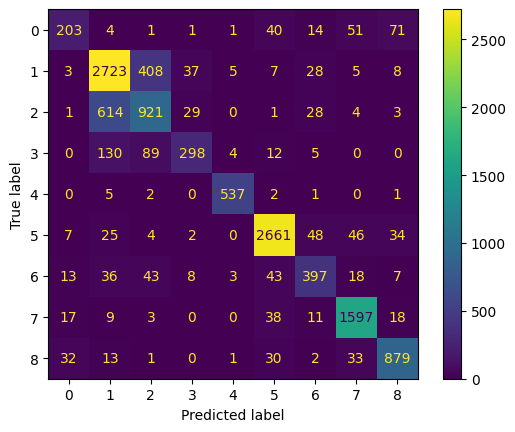

In [41]:
print("------------------------- Evaluation Of the XGBoost Model -------------------------")
print('-----------------------------------------------------------------------------------')
evaluate_model(xgb_BM_model, X_test, y_encoded_test, metrics=metrics)

Not Totally bad, there is room for emprovement => So decided to do stacking models, to see what will happen if we combine models together 

## Model Stacking Experiment  

### Creating the Base Models pipline

In [51]:
base_models = {
    "lr_log": Pipeline([
        ("log", FunctionTransformer(np.log1p)),
        ("lr", LogisticRegression(
            max_iter=300
        ))
    ]),

    "rf_raw": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        max_features="sqrt"
    ),

    "knn_scaled": Pipeline([
        ("log", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=95,
            metric="euclidean",
            weights="distance"
        ))
    ])
}

In [61]:
# out of folds 
def generate_oof_predictions(models, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    n_classes = len(np.unique(y))
    oof_preds = {
        name: np.zeros((X.shape[0], n_classes))
        for name in models
    }
    
    # train on k-1 folds, predict on 1 fold, k times
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train = y[train_idx]

        for name, model in models.items():
            model.fit(X_train, y_train)
            oof_preds[name][val_idx] = model.predict_proba(X_val)

    return oof_preds


In [62]:
oof_preds = generate_oof_predictions(base_models, X_train, y_encoded_train)
X_meta_train = np.hstack(list(oof_preds.values()))

In [65]:
# to check which base Models contribute the best 
for name, preds in oof_preds.items():
    acc = accuracy_score(y_encoded_train, preds.argmax(axis=1))
    ll = log_loss(y_encoded_train, preds)
    print(f"{name}: accuracy={acc:.4f}, log_loss={ll:.4f}")

lr_log: accuracy=0.7604, log_loss=0.6383
rf_raw: accuracy=0.8066, log_loss=0.5893
knn_scaled: accuracy=0.7483, log_loss=0.7190


lr_log: accuracy=0.7614, log_loss=0.6345
rf_raw: accuracy=0.8102, log_loss=0.5823
knn_scaled: accuracy=0.7758, log_loss=1.0059

We can see that Knn does not contribute well so we may drop it 

### XGBoost as the Meta Model  

In [68]:
meta_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)


In [69]:
meta_model.fit(X_meta_train, y_encoded_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_class=array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object), ...)

In [71]:
# The whole pipline

In [72]:
for model in base_models.values():
    model.fit(X_train, y_encoded_train)


In [73]:
meta_features_test = []

for model in base_models.values():
    preds = model.predict_proba(X_test)
    meta_features_test.append(preds)

X_meta_test = np.hstack(meta_features_test)


In [74]:
meta_test_preds = meta_model.predict_proba(X_meta_test)

In [75]:
print("Final stacked log loss:",
      log_loss(y_encoded_test, meta_test_preds))

print("Final stacked accuracy:",
      accuracy_score(y_encoded_test,
                     meta_test_preds.argmax(axis=1)))
meta_test_preds = meta_model.predict_proba(X_meta_test)

Final stacked log loss: 0.4471692201003438
Final stacked accuracy: 0.8288623141564319


Better than the benchMark model => this methedology is working i am gonna take it to the next level

##  Advanced Classifier Model

Adding more base models and feature engineering

In [14]:
# this is for the Ranking-based features (The heighest value features ) which features are the biggest for this row ? 
def add_rank_features_np(X, k=4):
    """
    Generate ranking-based one-hot features for the top-k values per row.

    For each sample (row), the indices of the top-k largest feature values
    are identified. For each rank position, a one-hot vector of length
    n_features is created, resulting in k * n_features additional features.

    Parameters
    ----------
    X : np.ndarray of shape (n_samples, n_features)
        Input feature matrix.

    k : int, default=4
        Number of top-ranked features to encode per sample.

    Returns
    -------
    np.ndarray of shape (n_samples, k * n_features)
        One-hot encoded ranking features.
    """
    
    n_samples, n_features = X.shape
    topk_idx = np.argsort(X, axis=1)[:, -k:][:, ::-1]

    rank_feats = np.zeros((n_samples, k * n_features), dtype=np.float32)

    for i in range(n_samples):
        for r in range(k):
            rank_feats[i, r * n_features + topk_idx[i, r]] = 1.0

    return rank_feats
    
# to add to the pipeline   
class RankFeatureTransformer(BaseEstimator, TransformerMixin):
    """
    Scikit-learn compatible transformer that appends ranking-based features.

    This transformer computes one-hot encoded features indicating the
    indices of the top-k largest values in each sample and appends them
    to the original feature matrix.

    Parameters
    ----------
    k : int, default=4
        Number of top-ranked features to encode per sample.
    """
    def __init__(self, k=4):
        self.k = k

    def fit(self, X, y=None):
        self.n_features_ = X.shape[1]
        return self

    def transform(self, X):
        X_np = np.asarray(X)
        rank_feats = add_rank_features_np(X_np, k=self.k)
        return np.hstack([X_np, rank_feats])


In [11]:
# To use NN 
def build_nn(input_dim : int, n_classes: int, seed=None) -> Sequential:
    """
    Build and compile a simple feedforward neural network for multiclass classification.

    Architecture:
        Input → Dense(256) → Dropout → Dense(128) → Dropout → Softmax

    Parameters
    ----------
    input_dim : int
        Number of input features.

    n_classes : int
        Number of output classes.

    seed : int or None, default=None
        Random seed for reproducibility.

    Returns
    -------
    tensorflow.keras.Sequential
        Compiled Keras model.
    """
    
    if seed is not None:
        tf.keras.utils.set_random_seed(seed)

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(256, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [12]:
class PreprocessedKerasNN(BaseEstimator, ClassifierMixin):
    """
    Scikit-learn compatible wrapper for Keras neural networks with preprocessing.

    Supports:
    - Log or square-root feature transformations
    - Optional ranking-based feature augmentation
    - Feature scaling using StandardScaler

    Parameters
    ----------
    build_fn : callable
        Function that builds and returns a compiled Keras model.

    epochs : int, default=25
        Number of training epochs.

    batch_size : int, default=256
        Training batch size.

    seed : int or None, default=None
        Random seed for reproducibility.

    verbose : int, default=0
        Verbosity level for Keras training.

    transform : {"log", "sqrt"}, default="log"
        Feature transformation applied before scaling.

    feature_rank : bool, default=False
        Whether to append ranking-based features.

    rank_k : int, default=4
        Number of top-ranked features used if feature_rank=True.
    """
    
    def __init__(
        self,
        build_fn,
        epochs=100,
        batch_size=256,
        seed=None,
        verbose=0,
        transform="log",
        feature_rank=False,
        rank_k=4,
        early_stopping=True,
        patience=8,
        val_split=0.15
    ):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.seed = seed
        self.verbose = verbose
        self.transform = transform
        self.feature_rank = feature_rank
        self.rank_k = rank_k
        self.early_stopping = early_stopping # using early stoping method 
        self.patience = patience
        self.val_split = val_split


    def _transform_X(self, X):
        """
        Apply numeric transformation and optional ranking features.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        np.ndarray
            Transformed feature matrix.
        """
        X_np = np.asarray(X)
        if self.transform == "log":
            X_np = np.log1p(X_np)
        elif self.transform == "sqrt":
            X_np = np.sqrt(X_np + 0.375)

        features = [X_np]
        if self.feature_rank:
            rank_feats = add_rank_features_np(X_np, k=self.rank_k)
            features.append(rank_feats)

        return np.hstack(features)

    def fit(self, X, y):
        """
        Fit the neural network model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        y : array-like of shape (n_samples,)

        Returns
        -------
        self
        """
        X_t = self._transform_X(X)
        
        self.scaler_ = StandardScaler()
        X_t = self.scaler_.fit_transform(X_t)
        
        self.n_classes_ = len(np.unique(y))
        y_cat = to_categorical(y, self.n_classes_)
        
        self.model_ = self.build_fn(X_t.shape[1], self.n_classes_, self.seed)
        
        callbacks = []
        if self.early_stopping:
            callbacks.append(
                EarlyStopping(
                    monitor="val_loss",
                    patience=self.patience,
                    restore_best_weights=True,
                    verbose=self.verbose
                )
            )
        
        self.model_.fit(
            X_t,
            y_cat,
            epochs=self.epochs,
            batch_size=self.batch_size,
            validation_split=self.val_split,
            callbacks=callbacks,
            verbose=self.verbose
        )
        
        return self


    def predict_proba(self, X):
        """
        Predict class probabilities.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        np.ndarray of shape (n_samples, n_classes)
        """
        X_t = self._transform_X(X)
        X_t = self.scaler_.transform(X_t)
        return self.model_.predict(X_t, verbose=0)


### Stacking Classifier Class

In [13]:
class AdvancedStackingClassifier:
    """
    Advanced stacking ensemble for multiclass classification.

    Features:
    - Stratified K-fold out-of-fold predictions
    - Optional bagging of base models
    - Weighted ensemble of multiple meta models
    - Optional feature augmentation (nonzero counts, UMAP)

    Parameters
    ----------
    base_models : dict
        Dictionary of base estimators.

    meta_models : list of dict
        Each dict must contain:
        - "model": estimator with predict_proba
        - "coaf": float weight

    n_splits : int, default=5
        Number of CV folds For the OOF

    bagging_dict : dict or None, default=None
        Number of bags per base model.

    use_nonzero_feature : bool, default=True
        Whether to append nonzero-count feature.

    use_umap : bool, default=False
        Whether to append UMAP features.

    umap_model : object or None
        Preconfigured UMAP transformer.

    random_state : int, default=42
        Random seed.
    """
    def __init__(
        self,
        base_models: dict,
        meta_models: list[dict],
        n_splits=5,
        bagging_dict=None,   
        use_nonzero_feature=True,
        use_umap=False,
        umap_model=None,
        random_state=42
    ):
        
        self.base_models = base_models
        self.meta_models = meta_models
        self.n_splits = n_splits
        self.random_state = random_state

        self.bagging_dict = bagging_dict or {}
        self.use_nonzero_feature = use_nonzero_feature
        self.use_umap = use_umap
        self.umap_model = umap_model

        self.fitted_base_models_ = []
        self.n_classes_ = None

        # making sure that the coafs of the meta models add up to 1 
        total = sum(m["coaf"] for m in self.meta_models)
        for m in self.meta_models:
            m["coaf"] /= total

  
    # Feature Engineering
    def _augment_features(self, X):
        """
        Apply optional feature augmentation to input data.

        Augmentations include:
        - Nonzero feature count per sample
        - UMAP-transformed features

        Parameters
        ----------
        X : pandas.DataFrame
            Input feature matrix.

        Returns
        -------
        X_aug : pandas.DataFrame
            Augmented feature matrix.
        """
        X_aug = X.copy()

        if self.use_nonzero_feature:
            nonzero_count = (X_aug != 0).sum(axis=1)
            X_aug["nonzero_count"] = nonzero_count

        if self.use_umap:
            umap_features = self.umap_model.transform(X)
            for i in range(umap_features.shape[1]):
                X_aug[f"umap_{i}"] = umap_features[:, i]

        return X_aug
        
    def normalize_proba(self, p):
        """
        Normalize predicted probabilities so each row sums to 1.

        This is a safety step to correct minor numerical drift when
        blending multiple probabilistic models.

        Parameters
        ----------
        p : np.ndarray of shape (n_samples, n_classes)
            Raw probability predictions.

        Returns
        -------
        np.ndarray
            Row-normalized probability predictions.
        """
        return p / p.sum(axis=1, keepdims=True)


    def fit(self, X, y, verbose=True):
        """
        Fit the stacking ensemble.

        Workflow:
        1. Optionally fit UMAP on training data.
        2. Generate OOF predictions for each base model using stratified CV.
        3. Retrain each base model on the full training set.
        4. Train meta models on concatenated OOF predictions.

        Parameters
        ----------
        X : pandas.DataFrame
            Training features.

        y : array-like of shape (n_samples,)
            Encoded target labels.

        verbose : bool, default=True
            Whether to print training progress and metrics.

        Returns
        -------
        self : AdvancedStackingClassifier
            Fitted instance.
        """
        start_total = time.time()
        
        X = X.reset_index(drop=True)
        y = np.asarray(y)

        if self.use_umap:
            self.umap_model.fit(X)

        X_aug = self._augment_features(X)

        self.n_classes_ = len(np.unique(y))
        n_samples = X.shape[0]

        skf = StratifiedKFold(
            n_splits=self.n_splits,
            shuffle=True,
            random_state=self.random_state
        )

        oof_meta_features = []

        # looping through base models 
        for name, model in self.base_models.items():
            n_bags = self.bagging_dict.get(name, 1)

            for bag in range(n_bags):
                model_start = time.time()
                if verbose:
                    print(f"\nTraining {name} (bag {bag+1}/{n_bags})")

                oof_preds = np.zeros((n_samples, self.n_classes_))

                for fold, (tr, val) in enumerate(skf.split(X_aug, y), 1):
                    model_clone = clone(model)
                    model_clone.fit(X_aug.iloc[tr], y[tr])
                    oof_preds[val] = model_clone.predict_proba(X_aug.iloc[val])

                oof_meta_features.append(oof_preds)

                model_clone = clone(model)
                model_clone.fit(X_aug, y)
                self.fitted_base_models_.append((name, model_clone))

                if verbose:
                    print(
                        f"OOF logloss: {log_loss(y, oof_preds):.4f}, "
                        f"accuracy: {accuracy_score(y, oof_preds.argmax(1)):.4f}, " 
                        f"Execution time for {name}: {time.time() - model_start:.1f}s"

                    )

        # Training meta model 
        X_meta_train = np.hstack(oof_meta_features)
        self.fitted_meta_models_ = []

        for m in self.meta_models:
            meta = clone(m["model"])
            meta.fit(X_meta_train, y)
            self.fitted_meta_models_.append({
                "model": meta,
                "coaf": m["coaf"]
            })
        
        if verbose:
            meta_preds = np.zeros((len(y), self.n_classes_))
            for m in self.fitted_meta_models_:
                meta_preds += m["coaf"] * m["model"].predict_proba(X_meta_train)
        
            meta_preds = self.normalize_proba(meta_preds)
            print("\nMeta models performance (OOF):")
            print("Meta Accuracy:", accuracy_score(y, meta_preds.argmax(1)))
            print("Meta LogLoss:", log_loss(y, meta_preds))
            print(f"\nTotal training time: {time.time() - start_total:.1f}s")


        return self

    
    def predict_proba(self, X):
        """
        Predict class probabilities for new data.

        Parameters
        ----------
        X : pandas.DataFrame
            Input features.

        Returns
        -------
        np.ndarray of shape (n_samples, n_classes)
            Normalized class probability predictions.
        """
        X = X.reset_index(drop=True)
        X_aug = self._augment_features(X)

        meta_features = []

        for name, model in self.fitted_base_models_:
            meta_features.append(model.predict_proba(X_aug))

        X_meta = np.hstack(meta_features)
        probs = np.zeros((X_meta.shape[0], self.n_classes_))
        for m in self.fitted_meta_models_:
            probs += m["coaf"] * m["model"].predict_proba(X_meta)
        
        return self.normalize_proba(probs)


    def predict(self, X):
        """
        Predict class labels for new data.

        Parameters
        ----------
        X : pandas.DataFrame
            Input features.

        Returns
        -------
        np.ndarray of shape (n_samples,)
            Predicted class indices.
        """
        return self.predict_proba(X).argmax(axis=1)


In [14]:
def log1p_clip(X):
    return np.log1p(np.clip(X, 0, None))

# Base Models 
base_models = {
    
    "lr_log": Pipeline([
        #("rank", RankFeatureTransformer(k=4)), #  didn't help 
        ("log", FunctionTransformer(np.log1p)),
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(
            max_iter=3000,
            solver="lbfgs",
            n_jobs=-1
    ))
    ]),

    "rf_raw": RandomForestClassifier(
        n_estimators=600,
        max_depth=None,
        random_state=42,
        max_features="sqrt"
    ),

    "knn_scaled": Pipeline([
        # ("imputer", SimpleImputer(strategy="median")), # this was for the Umap 
        ("log", FunctionTransformer(log1p_clip, validate=False)),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=95,
            metric="euclidean",
            weights="distance"
        ))
    ]), 
    
    "xgb": xgb.XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        n_estimators=200,
        max_depth=4,
        learning_rate=0.05
    )
}


for i in range(5):
    base_models[f"nn_sqrt_{i}"] = PreprocessedKerasNN(
        build_fn=build_nn,
        epochs=50, 
        patience=10,
        early_stopping=False,
        batch_size=256,
        seed=100 + i,
        transform="sqrt", 
        feature_rank=False
    )    

for i in range(10):
    base_models[f"nn_log_{i}"] = PreprocessedKerasNN(
        build_fn=build_nn,
        epochs=50,
        patience=10,
        early_stopping=False,
        batch_size=256,
        seed=42 + i,
        transform="log", 
        feature_rank = False
    )

# bagging_dict = {"rf_raw": 5} # decided not to use this because it didn't help 



In [15]:
# Meta Models 
xgb_meta = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=n_classes,
    n_estimators=350,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42
)

lr_meta = Pipeline([
    ("scaler", StandardScaler()), 
    ("lr", LogisticRegression(
        multi_class="multinomial",
        max_iter=3000,
        C=0.5,
        solver="lbfgs"
    )) 
])



meta_models = [{
    "model": xgb_meta, 
    "coaf": 1.0
}] 
# {
#     "model": lr_meta,  # didn't help  ( the coaf was 0.3 )
#     "coaf": 0
# }]


In [20]:
# using Umap 
umap_model = umap.UMAP(
    n_components=10,        
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)


In [22]:
stack = AdvancedStackingClassifier(
    base_models=base_models,
    meta_models=meta_models,
    n_splits=5
)

stack.fit(X_train, y_encoded_train)



Training lr_log (bag 1/1)
OOF logloss: 0.6380, accuracy: 0.7599, Execution time for lr_log: 30.5s

Training rf_raw (bag 1/1)
OOF logloss: 0.5897, accuracy: 0.8057, Execution time for rf_raw: 411.6s

Training knn_scaled (bag 1/1)
OOF logloss: 0.7133, accuracy: 0.7496, Execution time for knn_scaled: 12.4s

Training xgb (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
I0000 00:00:1768095981.379752  451476 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


OOF logloss: 0.6093, accuracy: 0.7806, Execution time for xgb: 49.3s

Training nn_sqrt_0 (bag 1/1)


I0000 00:00:1768095981.383778  451476 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1768095984.786083  451571 service.cc:152] XLA service 0x78f278007fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768095984.786121  451571 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768095984.786125  451571 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768095985.307462  451571 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768095987.568269  451571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure

OOF logloss: 0.5366, accuracy: 0.8041, Execution time for nn_sqrt_0: 178.9s

Training nn_sqrt_1 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5325, accuracy: 0.8046, Execution time for nn_sqrt_1: 174.5s

Training nn_sqrt_2 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5322, accuracy: 0.8072, Execution time for nn_sqrt_2: 173.8s

Training nn_sqrt_3 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5371, accuracy: 0.8038, Execution time for nn_sqrt_3: 172.8s

Training nn_sqrt_4 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5308, accuracy: 0.8064, Execution time for nn_sqrt_4: 174.8s

Training nn_log_0 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5447, accuracy: 0.8038, Execution time for nn_log_0: 172.1s

Training nn_log_1 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5432, accuracy: 0.8029, Execution time for nn_log_1: 172.6s

Training nn_log_2 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5479, accuracy: 0.8009, Execution time for nn_log_2: 173.4s

Training nn_log_3 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5446, accuracy: 0.8047, Execution time for nn_log_3: 169.7s

Training nn_log_4 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5476, accuracy: 0.8020, Execution time for nn_log_4: 171.4s

Training nn_log_5 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5400, accuracy: 0.8036, Execution time for nn_log_5: 176.3s

Training nn_log_6 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5423, accuracy: 0.8018, Execution time for nn_log_6: 172.2s

Training nn_log_7 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5452, accuracy: 0.8021, Execution time for nn_log_7: 170.7s

Training nn_log_8 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5396, accuracy: 0.8053, Execution time for nn_log_8: 173.6s

Training nn_log_9 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 0.5373, accuracy: 0.8041, Execution time for nn_log_9: 174.9s

Meta models performance (OOF):
Meta Accuracy: 0.8467536665185245
Meta LogLoss: 0.37618534633455014

Total training time: 3152.7s


Final log loss: 0.42663304010498704
Final accuracy: 0.8333063994828701
Confusion matrix:
 [[ 242    4    1    0    0   26   16   38   59]
 [   3 2673  441   50    6    7   33    5    6]
 [   3  547  972   40    1    1   31    4    2]
 [   0   98   85  338    3   12    2    0    0]
 [   0   10    0    0  537    0    1    0    0]
 [   9   13    2    3    1 2676   54   36   33]
 [  12   31   49    7    1   40  414   10    4]
 [  26   11    0    0    0   38   16 1580   22]
 [  33   15    1    0    2   29    1   29  881]]

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.63      0.68       386
           1       0.79      0.83      0.81      3224
           2       0.63      0.61      0.62      1601
           3       0.77      0.63      0.69       538
           4       0.97      0.98      0.98       548
           5       0.95      0.95      0.95      2827
           6       0.73      0.73      0.73       568
           7       

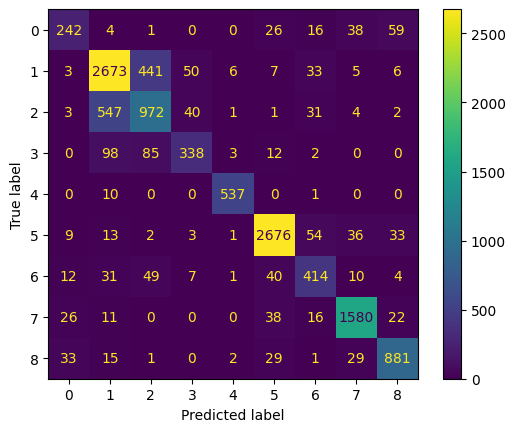

In [23]:
preds = stack.predict_proba(X_test)
y_pred = preds.argmax(axis=1)

print("Final log loss:", log_loss(y_encoded_test, preds))
print("Final accuracy:", accuracy_score(y_encoded_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_encoded_test, y_pred))
print("\nClassification report:\n",
      classification_report(y_encoded_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_encoded_test, y_pred)
# The best so far 
# Final log loss: 0.4254230561022298
# Final accuracy: 0.8350840336134454

In [24]:
# Saving the stack  
joblib.dump(stack, "/kaggle/working/stacking_model.pkl")

['/kaggle/working/stacking_model.pkl']

In [25]:
################ Cross Validation for the whole Pipeline #############

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

loglosses = []
accuracies = []


le = LabelEncoder()
y_encoded = le.fit_transform(y)
n_classes = len(le.classes_) 
cm_total = np.zeros((n_classes, n_classes), dtype=int)

for fold, (tr, val) in enumerate(cv.split(X, y_encoded), 1):
    print(f"\n===== OUTER FOLD {fold} =====")

    X_train, X_val = X.iloc[tr], X.iloc[val]
    y_train, y_val = y_encoded[tr], y_encoded[val]

    stack = AdvancedStackingClassifier(
        base_models=base_models,
        meta_models=meta_models,
        n_splits=5
    )

    stack.fit(X_train, y_train, verbose=False)

    preds = stack.predict_proba(X_val)
    y_pred = preds.argmax(1)

    loglosses.append(log_loss(y_val, preds))
    accuracies.append(accuracy_score(y_val, y_pred))
    cm_total += confusion_matrix(y_val, y_pred, labels=np.arange(n_classes))

print("\n==== CV RESULTS ====")
print(f"LogLoss: {np.mean(loglosses):.4f} ± {np.std(loglosses):.4f}")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")

print("\nAggregated Confusion Matrix:")
print(cm_total)



===== OUTER FOLD 1 =====

===== OUTER FOLD 2 =====

===== OUTER FOLD 3 =====

==== CV RESULTS ====
LogLoss: 0.4453 ± 0.0017
Accuracy: 0.8273 ± 0.0019

Aggregated Confusion Matrix:
[[ 1143    34     9     3     7   136    64   216   317]
 [   10 13511  2102   235    22    34   148    30    30]
 [    7  3027  4569   175     1    12   182    20    11]
 [    1   618   377  1559    15    67    48     3     3]
 [    2    53     1     2  2660     3     9     4     5]
 [   73    65    12    25     2 13389   197   211   161]
 [   53   184   199    30    10   161  2092    90    20]
 [  134    67    20     0     3   171    78  7870   121]
 [  160    57     5     2     7   143    27   153  4401]]


In [ ]:
# loading the stack 
# stack = joblib.load("/kaggle/input/YOUR_DATASET/stack.pkl")

##  Training on the entire train data For Kaggle challenge submission

In [17]:
sub_stack = AdvancedStackingClassifier(
    base_models=base_models,
    meta_models=meta_models,
    n_splits=5,
)

sub_stack.fit(X, y_encoded)


Training lr_log (bag 1/1)
OOF logloss: 0.6339, accuracy: 0.7616, Execution time for lr_log: 30.9s

Training rf_raw (bag 1/1)
OOF logloss: 0.5742, accuracy: 0.8105, Execution time for rf_raw: 411.7s

Training knn_scaled (bag 1/1)
OOF logloss: 0.6993, accuracy: 0.7548, Execution time for knn_scaled: 15.6s

Training xgb (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
I0000 00:00:1768121407.424742      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768121407.428631      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


OOF logloss: 0.6044, accuracy: 0.7834, Execution time for xgb: 50.6s

Training nn_sqrt_0 (bag 1/1)


I0000 00:00:1768121409.902719     199 service.cc:152] XLA service 0x7a818c004e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768121409.902756     199 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768121409.902762     199 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768121410.167675     199 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768121411.835667     199 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.7692, accuracy: 0.7470, Execution time for nn_sqrt_0: 170.8s

Training nn_sqrt_1 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6795, accuracy: 0.7469, Execution time for nn_sqrt_1: 168.4s

Training nn_sqrt_2 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6228, accuracy: 0.7484, Execution time for nn_sqrt_2: 168.0s

Training nn_sqrt_3 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6713, accuracy: 0.7485, Execution time for nn_sqrt_3: 165.9s

Training nn_sqrt_4 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.8134, accuracy: 0.7462, Execution time for nn_sqrt_4: 168.1s

Training nn_log_0 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.5478, accuracy: 0.7451, Execution time for nn_log_0: 166.0s

Training nn_log_1 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.7188, accuracy: 0.7461, Execution time for nn_log_1: 167.9s

Training nn_log_2 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.3984, accuracy: 0.7456, Execution time for nn_log_2: 170.0s

Training nn_log_3 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6813, accuracy: 0.7471, Execution time for nn_log_3: 168.0s

Training nn_log_4 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.4827, accuracy: 0.7461, Execution time for nn_log_4: 166.7s

Training nn_log_5 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.5502, accuracy: 0.7459, Execution time for nn_log_5: 168.3s

Training nn_log_6 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.7182, accuracy: 0.7457, Execution time for nn_log_6: 169.0s

Training nn_log_7 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6991, accuracy: 0.7464, Execution time for nn_log_7: 167.9s

Training nn_log_8 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.7167, accuracy: 0.7456, Execution time for nn_log_8: 167.2s

Training nn_log_9 (bag 1/1)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


OOF logloss: 2.6133, accuracy: 0.7470, Execution time for nn_log_9: 168.5s

Meta models performance (OOF):
Meta Accuracy: 0.8471993277093636
Meta LogLoss: 0.37871192430102013

Total training time: 3080.9s


In [18]:
joblib.dump(sub_stack, "/kaggle/working/substacking_model.pkl")

['/kaggle/working/substacking_model.pkl']

In [19]:
test_data = pd.read_csv("/kaggle/input/otto-group-product-classification-challenge/test.csv")
test_data.shape

(144368, 94)

In [22]:
test_ids = test_data['id']
sub_X = test_data.drop(columns=["id"])

In [23]:
sub_probs = sub_stack.predict_proba(sub_X)

submission = pd.DataFrame(
    sub_probs,
    columns=le.classes_
)

submission.insert(0, "id", test_ids)

submission.to_csv("/kaggle/working/submission.csv", index=False)